In [1]:
import control

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [3]:
num = np.array([8])
den = np.array([1, 1.6, 4])

Gs = control.tf(num, den)
Gs

TransferFunction(array([8]), array([1. , 1.6, 4. ]))

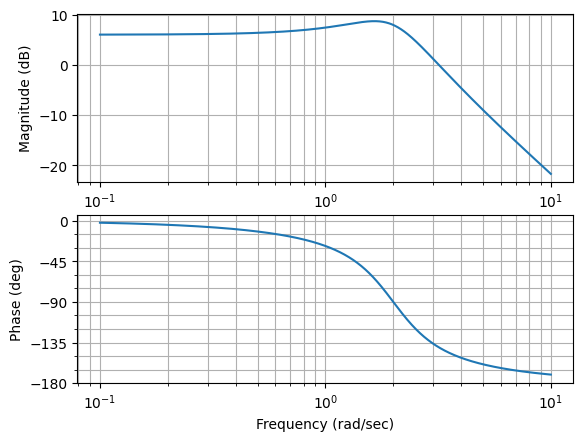

In [4]:
# Bode diagram
control.bode(Gs, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

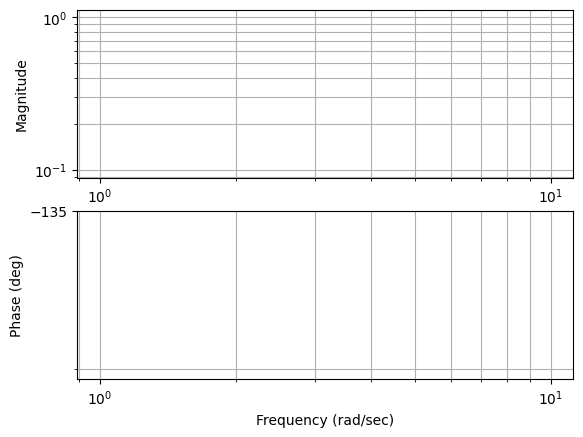

In [5]:
m = control.bode(Gs, omega=3.333)

In [6]:
m

(array([0.90021244]), array([-2.49798953]), array([3.333]))

In [7]:
m[1] * 180 / 3.14159265

array([-143.1242574])

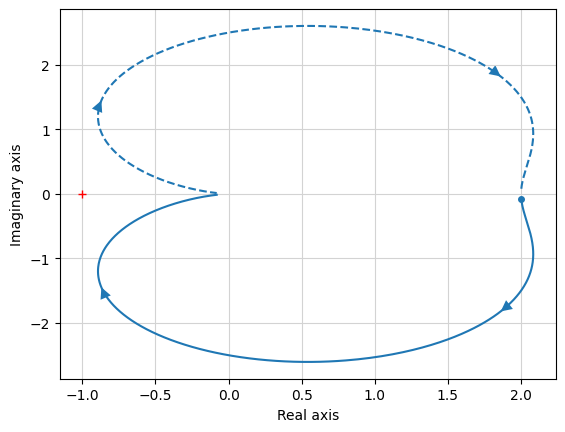

In [8]:
# Nyquist diagram
control.nyquist(Gs, omega_limits=(0.1, 10), plot=True);

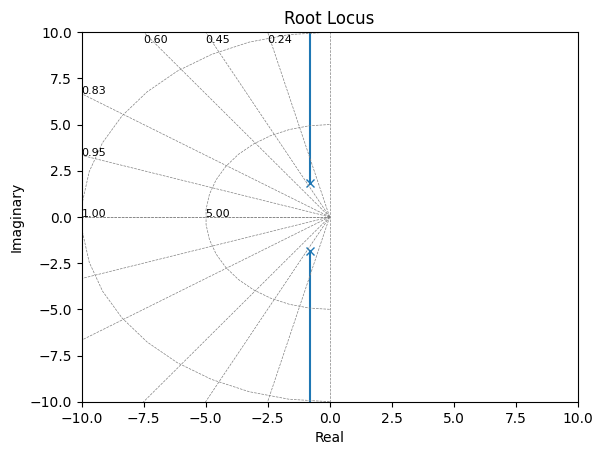

In [9]:
# Root locus
control.rlocus(Gs, kvect=np.linspace(0, 10, 1000), xlim=(-10, 10), ylim=(-10, 10), plot=True);

In [10]:
# Margin gain and phase
'''
    gm (float) – Gain margin

    pm (float) – Phase margin (in degrees)

    wcg (float or array_like) – Crossover frequency associated with gain margin (phase crossover frequency), where phase crosses below -180 degrees.

    wcp (float or array_like) – Crossover frequency associated with phase margin (gain crossover frequency), where gain crosses below 1.
'''

gm, pm, wcg, wcp = control.margin(Gs)
print('Margem de ganho: ', gm)
print('Margem de fase: ', str(pm) + ' graus')
print('Frequência associada com a margem de ganho: ', str(wcg) + ' Rad/seg')
print('Frequência associada com a margem de fase: ', str(wcp) + ' Rad/seg')

Margem de ganho:  inf
Margem de fase:  39.61231058053758 graus
Frequência associada com a margem de ganho:  nan Rad/seg
Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg


Questão 2

O teorema do valor final diz que:

   lim_{t->inf}f(t) = lim_{s->0}sF(s)
   
   onde f(t) é a resposta ao degrau e F(s) é a função de transferência

Para o sistema em questão, temos:

   lim_{t->inf}y(t) = lim_{s->0}sY(s)

   onde y(t) é a resposta ao degrau e Y(s) é a função de transferência

Considerando um controlador PD da forma:

   C(s) = (Kp + Kd*s)E(s)

Temos o seguinte sistema compensado:

   Gc(s) = G(s)C(s) = (Kp + Kds)E(s)*G(s)

   Gc(s) = (Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)

   Pelo teorema do valor final:

   val_final = lim_{s->0}{s(Kp + Kds)E(s)8 / (s^2 + 1,6s + 4)}

   Considerando E(s) = 1/s:

   val_final = lim_{s->0}{(Kp + Kds)8 / (s^2 + 1,6s + 4)} = 8/4 = 2

Portanto com um controlador PD não e possivel zerar o erro em regime permanente, visto que ele não adiciona um polo na origem
   


In [80]:
#PD controller
Kp = 2
Kd = 0.1
C = control.tf([Kd, Kp],[1])
C

TransferFunction(array([0.1, 2. ]), array([1]))

In [81]:
Gc = control.series(C, Gs)
Gc

TransferFunction(array([ 0.8, 16. ]), array([1. , 1.6, 4. ]))

In [82]:
#Reposta ao degrau
yout, T = control.step_response(Gc)

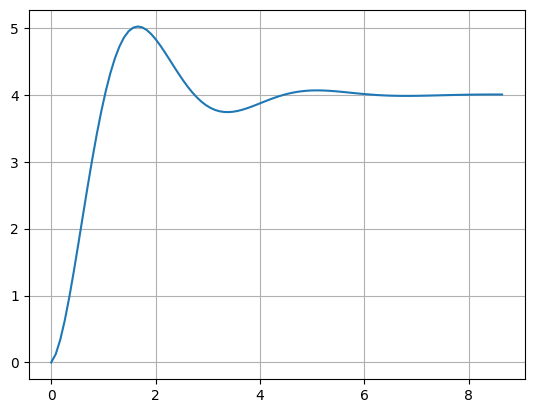

In [83]:
plt.plot(yout,T)
plt.grid()

Considerando o controlador:
    C(s) = a1s + a0 / b1s + 1

    1. Nova frequência de cruzamento de ganho: 2 rad/s

    2. Margem de Fase: 60°

    3. Adote o valor de a0 = 0,8

    Com isso ja temos: 

    C(s) = a1s + 0.8 / b1s + 1

Dados do sistema sem controlador:

Margem de ganho:  inf

Margem de fase:  39.61231058053758 graus

Frequência associada com a margem de ganho:  nan Rad/seg

Frequência associada com a margem de fase:  3.1879476381760603 Rad/seg

In [137]:
a0 = 1.8

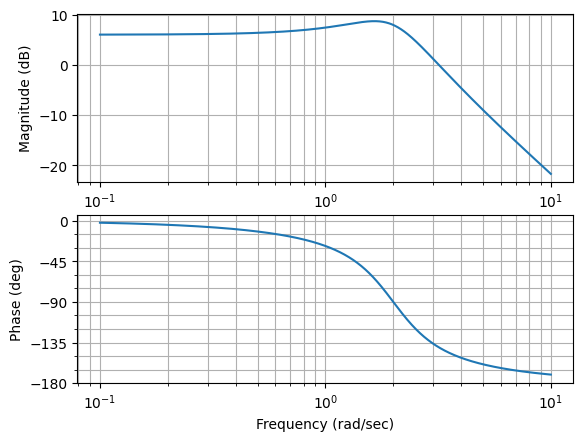

In [84]:
# Bode diagram
control.bode(Gs, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

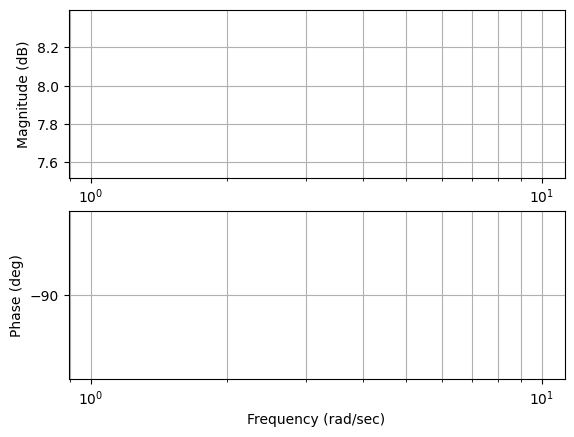

In [17]:
magJW, phase, omega = control.bode(Gs, dB =True,omega = 2)

In [36]:
phase * (180 / 3.14159265)

array([-90.0000001])

In [19]:
magJW

array([2.5])

In [20]:
#Temos 
phi = -180 + 60 - (phase[0] * (180 / 3.14159265))
phi

-29.99999989716001

In [37]:
magJW

array([2.5])

In [22]:
phase

array([-1.57079633])

In [23]:
from math import pi


SatJW = 2j
SatJW

2j

In [24]:
absGsJW = abs(8 / ((SatJW)**2 + 1.6*SatJW +4))
absGsJW

2.5

In [25]:
wcp

3.1879476381760603

In [138]:
# Calculo do a1

from math import cos, pi, sin


a_1 = (1 - a0*absGsJW*cos(phi*(pi/180)))/((2)*absGsJW*sin(phi*(pi/180)))
a_1 

1.1588457320300758

In [139]:
#Calculando b1
b_1 = (cos(phi*(pi/180)) - a0*abs(magJW))/((2)*sin(phi*(pi/180)))
b_1 = b_1[0]
b_1

3.6339746066156016

In [140]:
Cav = control.tf([a_1, a0], [b_1, 1])
Cav

TransferFunction(array([1.15884573, 1.8       ]), array([3.63397461, 1.        ]))

In [141]:
SisCont = control.series(Gs, Cav)
SisCont

TransferFunction(array([ 9.27076586, 14.4       ]), array([ 3.63397461,  6.81435937, 16.13589843,  4.        ]))

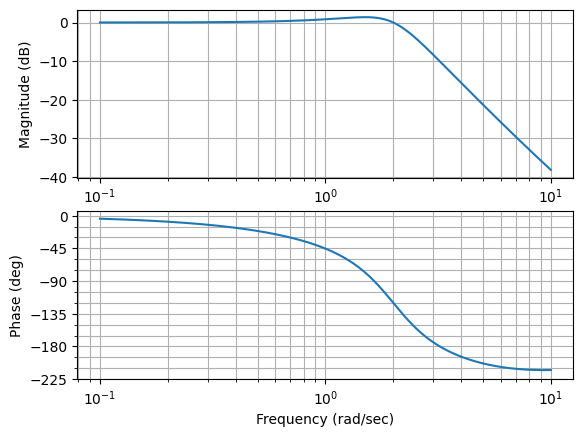

In [111]:
# Bode diagram
control.bode(SisCont, dB=True, Hz=False, omega_limits=(0.1, 10), plot=True);

In [112]:
gm1, pm1, wcg1, wcp1 = control.margin(SisCont)
print('Margem de ganho: ', gm1)
print('Margem de fase: ', str(pm1) + ' graus')
print('Frequência associada com a margem de ganho: ', str(wcg1) + ' Rad/seg')
print('Frequência associada com a margem de fase: ', str(wcp1) + ' Rad/seg')

Margem de ganho:  3.178395994391552
Margem de fase:  60.00000010284003 graus
Frequência associada com a margem de ganho:  3.2176195101959344 Rad/seg
Frequência associada com a margem de fase:  1.9999999999999998 Rad/seg


In [55]:
control.step_info(Gs)

{'RiseTime': 0.7849721907934246,
 'SettlingTime': 4.273737483208645,
 'SettlingMin': 1.8713235227388838,
 'SettlingMax': 2.5067242179588427,
 'Overshoot': 25.336210897942134,
 'Undershoot': 0,
 'Peak': 2.5067242179588427,
 'PeakTime': 1.7443826462076104,
 'SteadyStateValue': 2.0}

In [56]:
control.step_info(SisCont)

{'RiseTime': 1.3955061169660887,
 'SettlingTime': 4.709833144760549,
 'SettlingMin': 1.4519358024577353,
 'SettlingMax': 1.6001414061764807,
 'Overshoot': 0.008837886030038655,
 'Undershoot': 0,
 'Peak': 1.6001414061764807,
 'PeakTime': 5.843681864795497,
 'SteadyStateValue': 1.6}

In [142]:
T1, yout1 = control.step_response(SisCont)

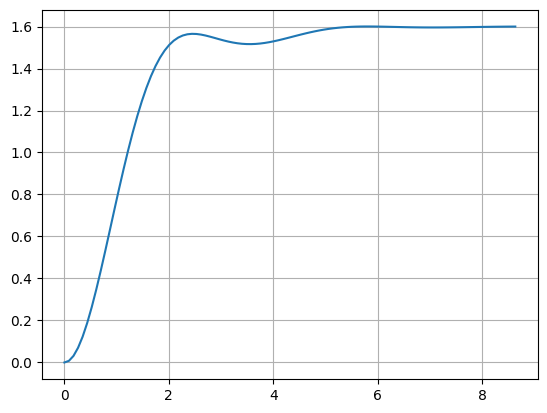

In [68]:
plt.plot(T1, yout1)
plt.grid()

In [143]:
T, yout = control.step_response(control.feedback(SisCont))

In [144]:
T2, yout2 = control.step_response(control.feedback(Gs), T = T)

In [100]:
abs(control.pole(control.feedback(SisCont)))

array([2.47672045, 2.47672045, 0.78869341])

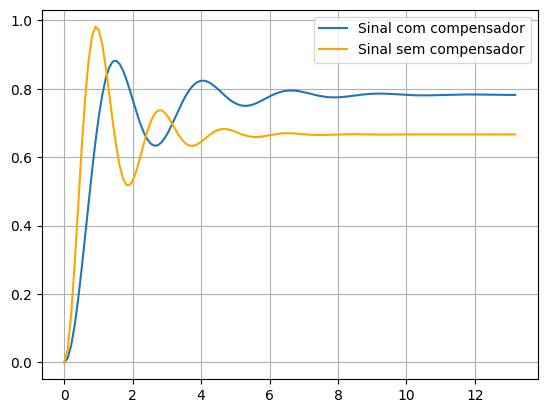

In [145]:
plt.plot(T, yout, label = 'Sinal com compensador')
plt.plot(T2, yout2, color = 'orange', label =  'Sinal sem compensador')
plt.legend()
plt.grid()

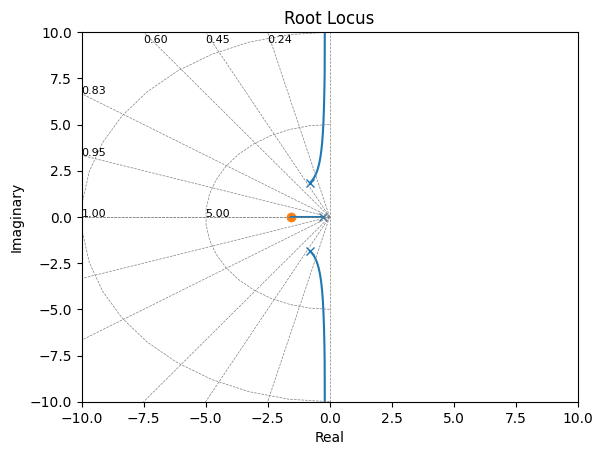

In [146]:
# Root locus
control.rlocus(SisCont, kvect=np.linspace(0, 10, 1000), xlim=(-10, 10), ylim=(-10, 10), plot=True);

In [147]:
control.step_info(control.feedback(SisCont))

{'RiseTime': 0.7095235156997778,
 'SettlingTime': 5.878909130083874,
 'SettlingMin': 0.6335822923384964,
 'SettlingMax': 0.88215635098456,
 'Overshoot': 12.719978181360426,
 'Undershoot': 0,
 'Peak': 0.88215635098456,
 'PeakTime': 1.520407533642381,
 'SteadyStateValue': 0.7826086956521741}

In [148]:
control.step_info(control.feedback(Gs))

{'RiseTime': 0.3597789207803196,
 'SettlingTime': 4.892993322612345,
 'SettlingMin': 0.5166612670788283,
 'SettlingMax': 0.9829210447655828,
 'Overshoot': 47.43815671483743,
 'Undershoot': 0,
 'Peak': 0.9829210447655828,
 'PeakTime': 0.9354251940288307,
 'SteadyStateValue': 0.6666666666666666}